In [1]:
sparkR.session()

full_path <- function(file_path) {
    working_bucket <- "S3_BUCKET"
    output_directory <- "processed_jupyter_sparkr"
    sprintf("s3a://%s/%s/%s", working_bucket, output_directory, file_path)
}

Java ref type org.apache.spark.sql.SparkSession id 1 

## Load Carriers data

In [2]:
carriers <- read.df(full_path("carriers"), "parquet")
createOrReplaceTempView(carriers, "carriers")
printSchema(carriers)
head(carriers, 20)

root
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)


Code,Description
02Q,Titan Airways
04Q,Tradewind Aviation
05Q,"Comlux Aviation, AG"
06Q,Master Top Linhas Aereas Ltd.
07Q,Flair Airlines Ltd.
09Q,"Swift Air, LLC"
0BQ,DCA
0CQ,ACM AIR CHARTER GmbH
0FQ,"Maine Aviation Aircraft Charter, LLC"
0GQ,"Inter Island Airways, d/b/a Inter Island Air"


## Load Airports data

In [3]:
airports <- read.df(full_path("airports"), "parquet")
createOrReplaceTempView(airports, "airports")
printSchema(airports)
head(airports, 20)

root
 |-- iata: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)


iata,airport,city,state,country,lat,long
00M,Thigpen,Bay Springs,MS,USA,31.95376,-89.23450
00R,Livingston Municipal,Livingston,TX,USA,30.68586,-95.01793
00V,Meadow Lake,Colorado Springs,CO,USA,38.94575,-104.56989
01G,Perry-Warsaw,Perry,NY,USA,42.74135,-78.05208
01J,Hilliard Airpark,Hilliard,FL,USA,30.68801,-81.90594
01M,Tishomingo County,Belmont,MS,USA,34.49167,-88.20111
02A,Gragg-Wade,Clanton,AL,USA,32.85049,-86.61145
02C,Capitol,Brookfield,WI,USA,43.08751,-88.17787
02G,Columbiana County,East Liverpool,OH,USA,40.67331,-80.64141
03D,Memphis Memorial,Memphis,MO,USA,40.44726,-92.22696


## Load Flights data

In [4]:
flights <- read.df(full_path("flights"), "parquet")
createOrReplaceTempView(flights, "flights")
printSchema(flights)
head(flights, 10)[c("ArrDelay","CarrierDelay","WeatherDelay","Distance")]

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)

ArrDelay,CarrierDelay,WeatherDelay,Distance
-14,0,0,810
2,0,0,810
14,0,0,515
-6,0,0,515
34,2,0,515
11,0,0,688
57,10,0,1591
-18,0,0,1591
2,0,0,451
-16,0,0,451


## Taxonomy for ArrDelay, CarrierDelay, and Distance colums

In [5]:
head(summary(flights))[c("summary", "ArrDelay","CarrierDelay","Distance")]

summary,ArrDelay,CarrierDelay,Distance
count,7009728,7009728,7009728
mean,7.9881812817844,3.430691889899294,726.3870294253928
stddev,38.0936193894022,19.80134736355125,562.1018034840309
min,-519,0,11
max,2461,2436,4962


## Let's find the top 10 of the most unpunctual airlines

Using Carrier as id variables


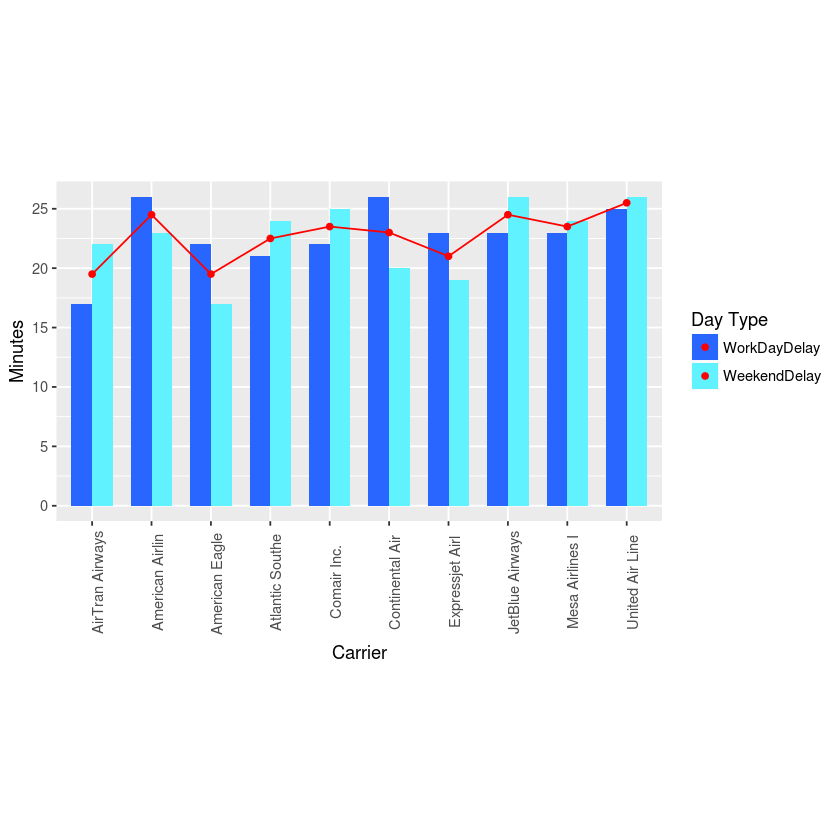

In [6]:
library(ggplot2)
library(reshape2)

delay_sql <- sql("
SELECT SUBSTR(c.description, 0, 15) as Carrier, WorkDayDelay, WeekendDelay 
FROM
       (SELECT CEIL( AVG(f.ArrDelay + f.DepDelay) ) as WorkDayDelay, f.UniqueCarrier
        FROM flights f
        WHERE f.DayOfWeek < 6
        GROUP BY f.UniqueCarrier 
        ORDER BY WorkDayDelay desc 
        LIMIT 10) t
    JOIN
       (SELECT CEIL( AVG(f.ArrDelay + f.DepDelay) ) as WeekendDelay, f.UniqueCarrier
        FROM flights f
        WHERE f.DayOfWeek > 5
        GROUP BY f.UniqueCarrier) t1
      ON t.UniqueCarrier = t1.UniqueCarrier
    JOIN carriers c 
      ON t.UniqueCarrier = c.code 
ORDER BY WeekendDelay DESC, WorkDayDelay DESC
")

delay <- collect(delay_sql)
delay_melt <- melt(delay[c('Carrier', 'WorkDayDelay', 'WeekendDelay')])

color_range_days <- c("#2966FF", "#61F2FF")

ggplot(data=delay_melt, aes(x=Carrier, y=value, fill=variable)) +
    geom_bar(stat="identity", width=.7, position="dodge") +
    stat_summary(fun.y=mean, geom = "line", mapping = aes(group = 1), color="red") +
    stat_summary(fun.y=mean, geom = "point", mapping = aes(group = 1), color="red") +
    theme(legend.position="right", axis.text.x=element_text(angle=90)) +
    labs(x="Carrier", y="Minutes", fill="Day Type") +
    coord_fixed(ratio = .2) +
    scale_fill_manual(values=color_range_days) +
    scale_y_continuous(breaks=seq(0, 30, 5))

## Number of flight performed by top companies

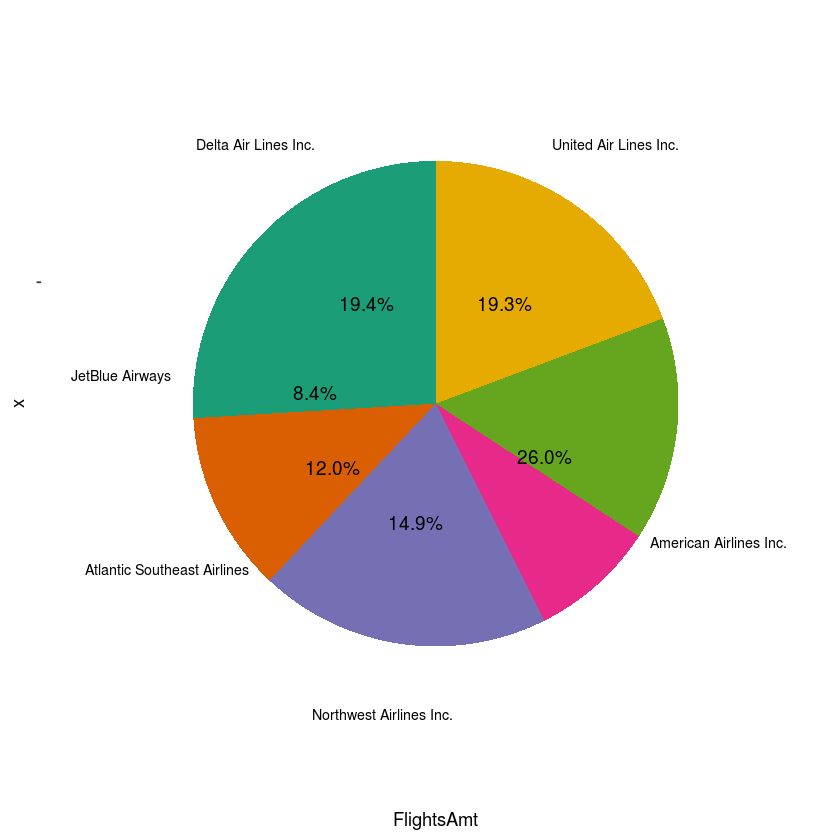

In [7]:
top_flights_sql <- sql("
SELECT t.cnt as FlightsAmt, carriers.description as Carrier 
FROM (
    SELECT count(*) as cnt, flights.UniqueCarrier as carrier_code 
    FROM flights 
    GROUP BY flights.UniqueCarrier LIMIT 6) t 
LEFT JOIN carriers 
  ON t.carrier_code = carriers.code
")

top_flights <- collect(top_flights_sql)

ggplot(transform(transform(top_flights, value=FlightsAmt/sum(FlightsAmt)), labPos=cumsum(FlightsAmt)-FlightsAmt/2), 
       aes(x="", y = FlightsAmt, fill = Carrier)) +
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_brewer(palette="Dark2") +
    theme_bw() +
    theme(axis.text.x=element_blank() ,panel.grid.major=element_blank(),panel.grid.minor = element_blank(),panel.border = element_blank()) +
    geom_text(size=4, aes(y=labPos, label=scales::percent(value))) + 
    geom_text(size=3, aes(x=1.8, y=labPos, label=top_flights$Carrier)) + 
    theme(legend.position="none")

## The average Flight Distance per Company

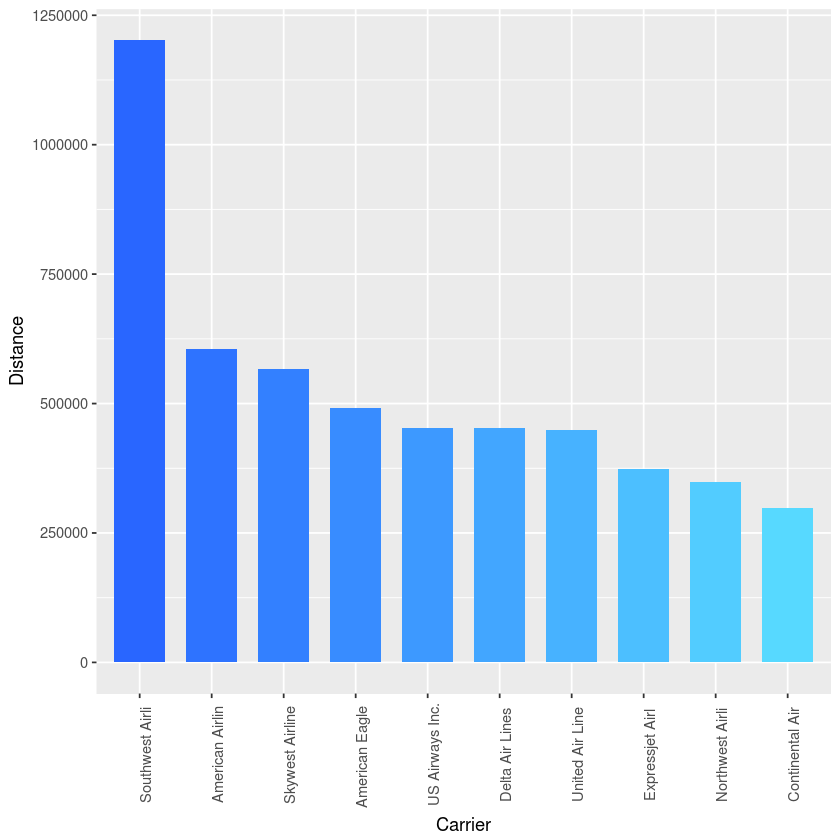

In [8]:
distance_sql = sql("
SELECT SUBSTR(c.description, 0, 15) as Carrier, COUNT(Distance) AS Distance 
FROM flights f 
JOIN carriers c 
  ON f.UniqueCarrier = c.code 
GROUP BY c.description 
ORDER BY distance DESC 
LIMIT 10
")

distance <- collect(distance_sql)

distance$Carrier <- factor(distance$Carrier, levels = distance$Carrier[order(-distance$Distance)])

color_range <-  c("#2966FF", "#2E73FF","#3380FF", "#388CFF", "#3D99FF", "#42A6FF", "#47B2FF", "#4CBFFF", "#52CCFF", 
                  "#57D9FF", "#5CE6FF", "#61F2FF", "#66FFFF")

ggplot(data=distance, aes(x=Carrier, y=Distance, fill=Carrier)) +
    geom_bar(stat="identity", width=.7, position="dodge") +
    theme(axis.text.x=element_text(angle=90)) +
    scale_fill_manual(values=color_range) +
    theme(legend.position="none")